<a href="https://colab.research.google.com/github/dinuka-rp/hand-gesture-rec/blob/main/AppliedAI_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand Gesture Recognition System

A Hand Gesture recognition system using Convolutional Neural Networks (CNNs).

Dataset: https://www.kaggle.com/gti-upm/leapgestrecog/version/1

In [ ]:
# import libraries needed for the project

%matplotlib inline
from google.colab import files
import datetime, os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

# print(tf.__version__)

>Hand Gesture | Label used
>--- | ---
> Thumb down | 0
> Palm (Horizontal) | 1
> L | 2
> Fist (Horizontal) | 3
> Fist (Vertical) | 4
> Thumbs up | 5
> Index | 6
> OK | 7
> Palm (Vertical) | 8
> C | 9

Table 1 - Classification used for every hand gesture.


T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)  

## Load the Dataset

In [ ]:
# mount Google Drive (from Colab)
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
dataset_file_path = "/content/drive/MyDrive/Datasets/AppliedAI/hand-gesture-dataset"

# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(dataset_file_path, topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

20005


Check if the dataset was loaded as expected.

In [ ]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


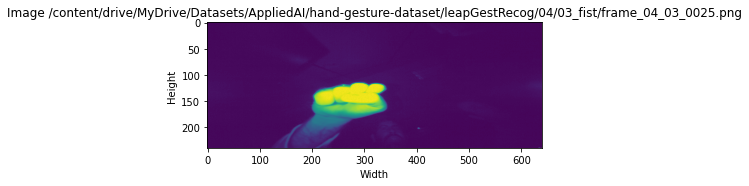

In [ ]:
plot_image(imagepaths[0]) # plot the first image from the imagepaths array

### Prepare images for training

Load all images into an array **X** & their respective labels into an array **Y**.

Since CNNs are generally used to identify shapes, RGB colour information is not necessary . Therefore, we can convert the images to grayscale in order to make the training process faster.

In [ ]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image - returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path
  category = path.split("/")[9]   # 6 + 3
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  20005
Labels loaded:  20005
3 /content/drive/MyDrive/Datasets/AppliedAI/hand-gesture-dataset/leapGestRecog/04/03_fist/frame_04_03_0025.png


Use sklearn's `train_test_split` to split the dataset into training & testing sets.

`random_state` is used to make the randomness of the produced results reproducible.

In [ ]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

## Creating the Model

In [ ]:
# Import of keras model and hidden layers to build the convolutional network

from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

### Constructing the CNN model

The first layer is expected to take-in the input image. Therefore, the input shape is set to expect the size of the image. The image is one dimensional.
Therefore, the final parameter of input shape has been set as 1.

**Relu** (Rectified Linear Unit has been used as the activation function for the convolution layers).
This prevents the *vanishing gradient* problem, while being computationally efficient.

---
All **Max-Pooling** layers have been given a 2 by 2 filter.

---

The **softmax** activation function in the final Dense layer is used as this is a multiclass classification problem. The softmax function is generally used in the final layer (as used here), which is the output layer of the neural network.


The dimensionality of the output is taken as 10 in the dense layer since the model is expected to identify 10 unique hand gestures.

In [ ]:
# Construction of the model
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

### Compiling and training the model

In [ ]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [ ]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
219/219 - 901s - loss: 0.7644 - accuracy: 0.9328 - val_loss: 0.0087 - val_accuracy: 0.9968 - 901s/epoch - 4s/step
Epoch 2/5
219/219 - 897s - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.0096 - val_accuracy: 0.9972 - 897s/epoch - 4s/step
Epoch 3/5
219/219 - 898s - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.0081 - val_accuracy: 0.9982 - 898s/epoch - 4s/step
Epoch 4/5
219/219 - 900s - loss: 0.0094 - accuracy: 0.9980 - val_loss: 0.0025 - val_accuracy: 0.9997 - 900s/epoch - 4s/step
Epoch 5/5
219/219 - 893s - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.0187 - val_accuracy: 0.9928 - 893s/epoch - 4s/step


### Saving Model

In [ ]:
# Save entire model to a HDF5 file
model.save('/content/drive/MyDrive/Colab Notebooks/AppliedAI/AppliedAI-CW/handrecognition_model.h5')

## Testing Model

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

188/188 [==============================] - 90s 478ms/step - loss: 0.0187 - accuracy: 0.9928
Test accuracy: 99.28%


In [ ]:
predictions = model.predict(X_test) # Make predictions towards the test set

In [ ]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(5, 5)

In [ ]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

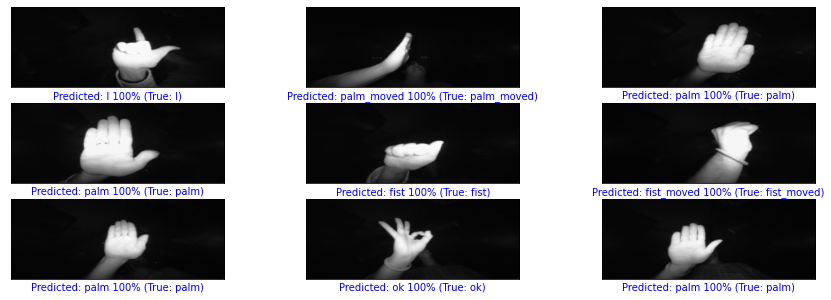

In [ ]:
validate_9_images(predictions, y_test, X_test)

In [ ]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [ ]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,589,0,0,0,0,0,0,0,0,0
Actual Palm (H),2,595,1,0,0,0,0,0,0,0
Actual L,0,0,573,0,0,0,0,0,0,0
Actual Fist (H),0,2,0,582,0,1,0,0,0,0
Actual Fist (V),0,0,0,0,572,0,0,0,0,0
Actual Thumbs up,0,0,0,1,0,607,0,0,0,0
Actual Index,0,0,1,0,32,0,581,0,1,0
Actual OK,0,0,0,0,0,0,0,655,0,0
Actual Palm (V),0,0,0,0,1,0,0,0,619,0
Actual C,0,0,0,0,1,0,0,0,0,586
